# Nested Sampler Introduction
Here, we will explain how to sample an orbit posterior using nested sampling from the `dynesty` package. An advantage of nested sampling is that it computes the evidence and posterior at the same time. To compute the evidence, Dynesty first uses live points to make iso-likelihood contours with probability greater than that of the previous contour. It then takes the integral of these contour shells and calculates prior “volumes” of these shells. As each contour is made, the live point with the least probability is removed (it “dies”), and it is replaced with a new live point sampled from the prior, which must have a higher probability. `dynesty` then uses these “dead” points to approximate the evidence integral by weighting each point and summing them. To estimate the posterior, dynesty then uses the calculated “dead” point weighting and evidence to get its importance weight, or the probability of the parameter set. For more info on how nested sampling works in `dynesty`, go to their [website](https://dynesty.readthedocs.io/en/stable/index.html).

In this tutorial, we will demonstrate how to generate a synthetic data set with a user-controlled orbit fraction (fraction of orbit covered by the synthetic data points) to feed into the nested sampler. We will also show plots using the sampler results from `dynesty` and save these results.


# Generate Synthetic Data
We generate synthetic data using the `generate_synthetic_data` function in `orbitize.system` to feed into the nested sampler. This function sets ground truth values for all of the parameters, the desired fractional orbit coverage, the number of observations, and the desired observational uncertainty. The observations are uniformly spaced synthetic data points covering the years 2001-2003 such that the orbital period and semi-major axis are determined by selecting the orbital fraction. A three year period is used for all orbits, so that for smaller orbit fraction, the orbit has a larger semi-major axis. The function then adds Gaussian noise to the observations to make them more realistic. This approach simulates similar observing strategies for orbits of varying lengths.

In [3]:
import orbitize
from orbitize import read_input, system, priors, sampler
import matplotlib.pyplot as plt
from orbitize.system import generate_synthetic_data
import numpy as np

# generate data
plx = 60.0 # [mas]
mtot = 1.2 # [M_sol]
orbit_frac = 95.
data_table, sma = generate_synthetic_data(orbit_frac, mtot, plx, num_obs=30)

# initialize orbitize System object
num_secondary_bodies = 1
sys = system.System(num_secondary_bodies, data_table, mtot, plx)
print(data_table)
lab = sys.param_idx

# other ground truth values
ecc = 0.5 
inc = np.pi/4 
aop = np.pi/4
pan = np.pi/4
tau = 0.8

      epoch        object        quant1       ... quant_type instrument
------------------ ------ ------------------- ... ---------- ----------
           51550.0      1  11.690679585649285 ...      radec      defrd
 51587.93103448276      1    36.7951190350705 ...      radec      defrd
51625.862068965514      1   53.44625230418348 ...      radec      defrd
51663.793103448275      1   57.74172150011931 ...      radec      defrd
51701.724137931036      1  43.476583812616035 ...      radec      defrd
 51739.65517241379      1   17.60198047834588 ...      radec      defrd
 51777.58620689655      1 -10.554719202310748 ...      radec      defrd
 51815.51724137931      1 -42.902152497869935 ...      radec      defrd
 51853.44827586207      1  -65.65070346148586 ...      radec      defrd
51891.379310344826      1  -92.15759521127484 ...      radec      defrd
               ...    ...                 ... ...        ...        ...
 52270.68965517241      1  -173.0917550491587 ...      radec    

# Running the Dynesty Sampler
`dynesty's` nested sampler has multiple prior bound shape options, as well as a static and dynamic nested sampler, more details of which can be found [here](https://dynesty.readthedocs.io/). These can also be configured in `run_sampler` keywords. Here we stick with the default options of a static sampler and 'multi' prior bound shape.

In [5]:
# fix some parameters for faster convergence
sys.sys_priors[lab['sma1']] = sma
sys.sys_priors[lab['aop1']] = np.pi/4 
sys.sys_priors[lab['pan1']] = np.pi/4
sys.sys_priors[lab['tau1']] = 0.8  
sys.sys_priors[lab['plx']] = plx
sys.sys_priors[lab['mtot']] = mtot

# run the nested sampler using 2 threads for parallelization
threads = 2
nested_sampler = sampler.NestedSampler(sys)
samples, num_iter = nested_sampler.run_sampler(num_threads = threads)

iter: 16803 | batch: 8 | bound: 6 | nc: 1 | ncall: 66312 | eff(%): 25.066 | loglstar: -130.534 < -126.270 < -126.777 | logz: -137.282 +/-  0.082 | stop:  0.902                                       

# Plotting
Full plotting capabilities of orbitize (including advanced corner and orbit plots) can be found in the [orbitize plotting tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Plotting_tutorial.html).

Here, we will plot the posterior samples from dynesty against the ground truth variables used to generate the synthetic data set.

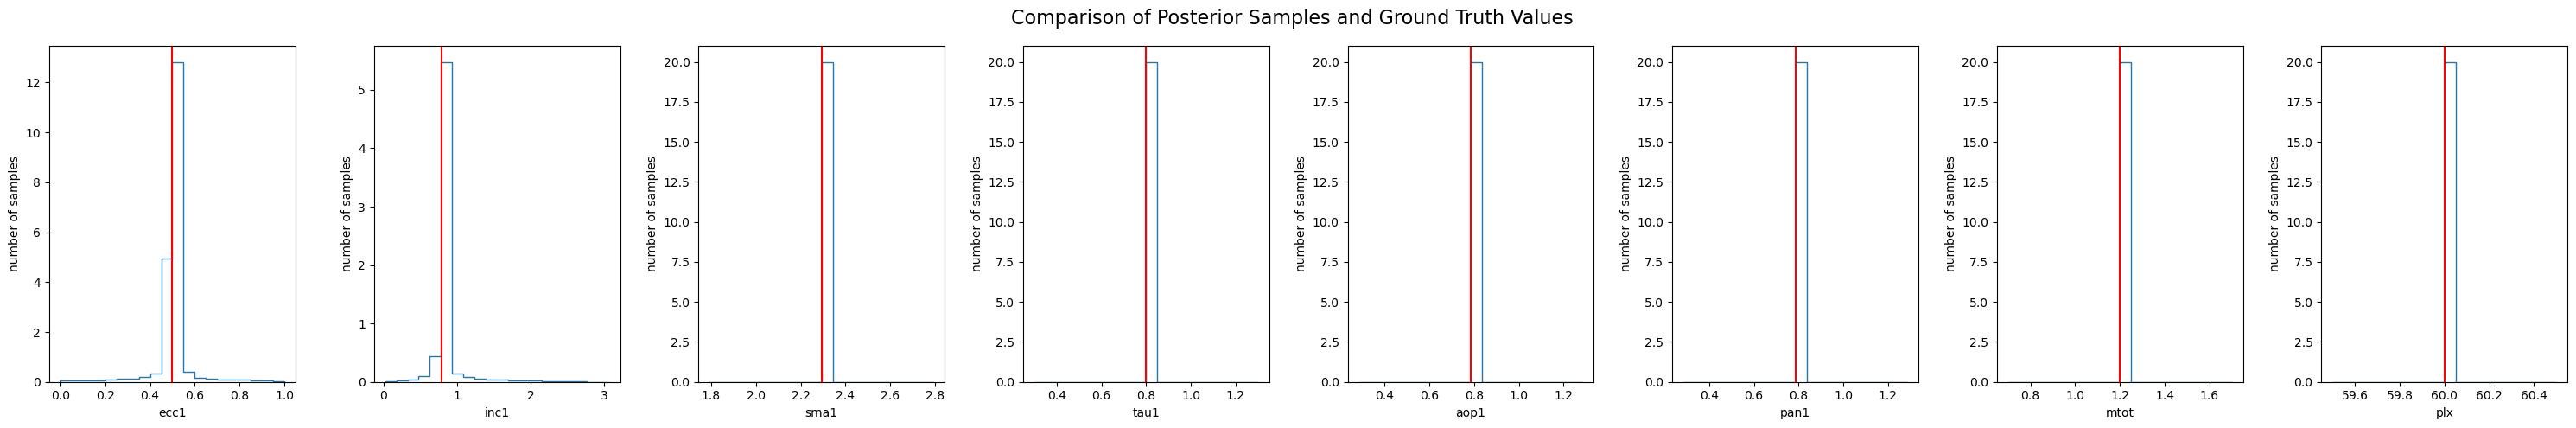

In [6]:
# plot posterior samples of each parameter with the groound truth value for comparison
fig, ax = plt.subplots(1,8, figsize=(30,5))
labels = ['ecc1', 'inc1', 'sma1', 'tau1', 'aop1', 'pan1', 'mtot', 'plx']
truth = [ecc, inc, sma, tau, aop, pan, mtot, plx]
for i in range(0,8):
    ax[i].hist(nested_sampler.results.post[:, lab[labels[i]]], bins = 20, density = True, histtype='step')
    ax[i].set_ylabel('number of samples')
    ax[i].set_xlabel(labels[i])
    ax[i].axvline(truth[i], color='red')
fig.suptitle('Comparison of Posterior Samples and Ground Truth Values', fontsize = 16)
plt.tight_layout()

# Saving Results

In [ ]:
# save results in .hdf5 format
filename = 'myposterior.hdf5'
nested_sampler.results.save_results(filename)